In [316]:
import math
import numpy as np
from sklearn.model_selection import KFold
import paper_code
# ALGORITHM 1
def Caratheodory(P,u):
    '''
        Input 
            P = points
            u = weight function
        Output:
            caratheodory set: (S,w) for (P,u)        
    '''
    # print('inside slow cara function')
    while True:
        # print(f'shapes of P {P.shape} and u {u.shape}')
        n = np.count_nonzero(u) 
        d = P.shape[1]
        if( n<=d+1):
            # print('Number of rows smaller than columns, do not need fast function',n,d)
            return u

        # select idx where u is nonzero
        u_non_zero = np.nonzero(u)
        A = P[u_non_zero] 
        
        # p1 = A[0] # although p0 -- but trying to be consistent the paper notation
        # A = A[1:] - p1
        
        reduced_vec = np.outer(A[0], np.ones(A.shape[0]-1, dtype = u.dtype))
        A = A[1:].T - reduced_vec
        

        # A'v  = 0 
        # ----------TODO -- CALCULATE V ---------------
        # compute V using SVD -- solve linear equations 
        # this is the most time consuming step of the entire thing
        # shape of V = {v2,v3,v4...vn} n-1

        _, _, V = np.linalg.svd(A, full_matrices=True)
        
        v  = V[-1] 
        
        v1 = v.sum() * -1
        v  = np.insert(v,0,v1,axis=0) # adding v1 back in position 0

        #         generates min alpha value where vi != 0
        #         alpha_min = math.inf
        #         for i in range(0,n):
        #             vi = v[i]
        #             ui = u[i]
        #             if(vi!= 0):
        #                 uivi = ui / vi
        #                 if(alpha_min>uivi):
        #                     alpha_min = uivi

        idx_good_alpha = np.nonzero(v > 0)
        
        alpha_min = np.min(u[u_non_zero][idx_good_alpha]/v[idx_good_alpha])
        # print('shape of u and v:',u[u_non_zero].shape,v.shape)
        w = np.zeros(u.shape[0] , dtype = u.dtype)
        tmp_w = u[u_non_zero] - alpha_min * v
        tmp_w[np.argmin(tmp_w)] = 0.0
        w[u_non_zero] = tmp_w
        w[u_non_zero][np.argmin(w[u_non_zero] )] = 0
        # print('cara func num of nonzero:', np.count_nonzero(w), w.shape[0])
        # print(w)
        u = w        

In [266]:
P = np.random.randn(40,3)
u = np.ones(40)
u1 = Caratheodory(P,u)
u2 = paper_code.Caratheodory(P,u)
print(np.count_nonzero(u1))
print(np.count_nonzero(u2))

4
4


In [267]:
u2 - u1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [332]:
def fast_Caratheodory_set(P,u,k):
    '''
    Input P = data points (n,d)
          u = weight function -- u(p)  
          k = accuracy vs speed factor
    Output 
          Returns a Carath set (P,u)
    '''
    iterr = 10
    while True:
        iterr -= 1
        # print('fast cath : shape of P',P.shape)
        n = np.count_nonzero(u)
        d = P.shape[1]
        u_nonzero = np.nonzero(u)
        # print(f'nonzero {n},d {d}, k{k}')
        # return if not enough rows:
        if(n<d+1 or n<k):
            # print('returning u',u)
            return u

        # step 4
        # partition into k clusters with atmost math.ceil(n/k) points
        p_clusters = [] # saves µk cluster indexes
        kf = KFold(n_splits=k)
        nz = np.array(u_nonzero).reshape(-1,1)    
        i = 0
        for _,idxs in kf.split(nz):
            p_clusters.append(idxs)
            i += 1    
        
        # step 5 -- get weight of the ith clusters
        mu = np.zeros((k,d),dtype=u.dtype) # weighted mean of Pi        
        u_dash = np.zeros(k, dtype = u.dtype) # weight of the ith cluster     
        
        for i,idxes in enumerate(p_clusters):
            denom = 0
            numer = 0
            for p_idx in idxs: # p is a d dimensional vector
                u_p = u[p_idx]
                p = P[p_idx]
                denom += u_p
                numer += u_p * p # --- TODO SHOULD BE NUMPY MULTIPLY
                
            mu[i] = numer / denom
            u_dash[i] = denom
        
        # step 8 --  return a smaller selected subset of mu
        w_dash = Caratheodory(mu,u_dash) # gives weight function with some zero values
        w_dash2 = paper_code.Caratheodory(mu,u_dash)
        #print('w dash shape should be k,1:',w_dash.shape, np.count_nonzero(w_dash))
        # step 9
        # for cluster in w_dash == 0, make u==0, so that Pi is removed
        w = np.zeros(u.shape[0],dtype=u.dtype)
        for w_idx in range(w_dash.shape[0]):
            if(w_dash[w_idx]!=0):                                
                for pi_idx in p_clusters[w_idx]:
                    w[pi_idx] = (w_dash[w_idx] * u[pi_idx]) / u_dash[w_idx]
                
        # print(f'fast_cara #non zero in u {np.count_nonzero(u)} and w {np.count_nonzero(w)}')
        # step 12 - recursively call fast cath
        u = w
        # print()

In [307]:
P = np.random.randn(40,10)
u = np.ones(40)
u1 = fast_Caratheodory_set(P,u,20)
print('non zero in u1:',np.count_nonzero(u1))

# u2 = paper_code.Fast_Caratheodory(P,u,7)
# print('non_zero in u2:',np.count_nonzero(u2))

Number of rows smaller than columns, do not need fast function 11 10
Number of rows smaller than columns, do not need fast function 11 10
non zero in u1: 13


In [ ]:
print(u1)
print()
print(u2)

In [333]:
# algorithm 2 
def Caratheodory_matrix(A,k):
    '''
    Input A: (n,d) A = (a1 | a2 | ... | an )^T  = n,d
          input data is column vector in the matrix
          k = numerical accuracy speed tradeoff          
    Output 
          S = (d*2 + 1,d) 
          with A^T *A = S^T *S
    '''
    #print('cath matrix shape of A:',A.shape)
    n,d = A.shape
    P = np.empty((n,d*d))
    u = np.zeros(n)
    
    # step 1
    for i in range(n):        
        ai = A[i].reshape(d,1)        
        # step 2
        pi   = np.multiply(ai,ai.transpose())
        P[i] = pi.flatten() # (d,d) set pi inside a data structure -- 
        u[i] = 1 / n
        
    #print('matrix: done with calculating ai*ai_transpose')    
    #print('matrix: shape of p and u',P.shape,u.shape)
    
    w = fast_Caratheodory_set(P,u,k)
    w_nonzero = np.nonzero(w)[0]   
#     print('____________________________')
#     print('shape of w returned:',w.shape)
#     print(' number of non zero items: ',np.count_nonzero(w))
#     print(w_nonzero)
    
    # step 6
    S = np.zeros((np.count_nonzero(w),d))
    #print(S.shape)
    i = 0
    for ai_idx in w_nonzero:
        w1 = w[ai_idx]
        a1 =  A[ai_idx].transpose()
        
        S[i] = np.sqrt(n*w1) *a1
        i += 1
    return S        

In [309]:
A = np.random.randn(40,2)
S = Caratheodory_matrix(A,7)
print(S.shape)

Number of rows smaller than columns, do not need fast function 5 4
Number of rows smaller than columns, do not need fast function 5 4
Number of rows smaller than columns, do not need fast function 5 4
Number of rows smaller than columns, do not need fast function 5 4
Number of rows smaller than columns, do not need fast function 5 4
Number of rows smaller than columns, do not need fast function 5 4
Number of rows smaller than columns, do not need fast function 5 4
____________________________
shape of w returned: (40,)
 number of non zero items:  6
(6, 2)


In [376]:
def fast_lms(A,b,m,k):
    '''
    Input  A = (n,d) matrix 
           b = (n) vector -- > Ax - b = 0
           m = number of cross validation folds
           k = accuracy vs speed tradeoff "in" {1,2...,n}
    Output 
           C = (md*2,d) -- matrix whose rows are scaled rows from A
           y = (d,) - vector
           
           C,y act as a replacement for A,b and have much smaller number of rows
           hence the training time thereon shold be much
           faster.
    '''
    # print('fast lms: shape of A:',A.shape,b.shape)
    n,d = A.shape
    
    # step 1 -- add b to A
    A_dash = np.concatenate((A,b),axis=1)
    #print('shape of A_dash:', A_dash.shape) # should be n,d+1
    kf = KFold(n_splits=m)
    S = []
    
    #step 3,4
    for _,idx in kf.split(A_dash):
        Ai = A_dash[idx]
        Si = Caratheodory_matrix(Ai,k)
        #print('shape of Si after caratheory matrix',Ai.shape,Si.shape)
        S.append(Si)
        
    # step 5 concatenate all Si's
    S = np.concatenate(S,axis=0)
    # print()
    print('fast_lms: shape of S:',S.shape) # should be m(d+1)^2,d+1
    # print(m*(d+1)**2 +m)
#     print(S.shape[1],d)
    # step 6
    C = S[:,0:d]
    y = S[:,-1]
    return C,y

In [372]:
n,d = 2000,3
m = 4
k = 20
A = np.random.uniform(low=0,high=1000,size=(n,d))
b = np.random.uniform(low=0,high=1000,size=(n,1))
C,y = fast_lms(A,b,m,k)
print(k,C.shape,y.shape)

# y_shape_list = []
# x = [20,40,50,75,100,125,200,300,400,500,505,507,510,600,700,800,900,1200,1500,1600,1800,1900]
# for k in x:    
#     C,y = fast_lms(A,b,m,k)
#     print(k,y.shape[0])
#     y_shape_list.append(y.shape[0])    

fast_lms: shape of S: (76, 4)
4 3
20 (76, 3) (76,)


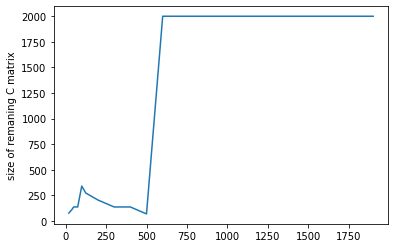

In [359]:
import matplotlib.pyplot as plt
plt.plot(x,y_shape_list)
plt.ylabel('size of remaning C matrix')
plt.show()

In [363]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

n,d = 50000,3
m,k = 4,500

A = np.random.uniform(low=0,high=1000,size=(n,d))
b = np.random.uniform(low=0,high=1000,size=(n,1))
C,y = fast_lms(A,b,m,k)
print(k,C.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(A,b,test_size=0.2)
reg = LinearRegression().fit(X_train, y_train)
score_simple = reg.score(X_test,y_test)

X_train, X_test, y_train, y_test = train_test_split(C,y,test_size=0.2)
reg = LinearRegression().fit(X_train, y_train)
score_fast = reg.score(X_test,y_test)

print(score_simple,score_fast)

100 (340, 4) (340,)
0.0006241927297582217 1.0


In [402]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# n,d = 50000,3
# m,k = 4,100

# X = np.random.uniform(low=0,high=1000,size=(n,d))
# y = np.random.uniform(low=0,high=1000,size=(n,1))

# A, X_test, b, y_test = train_test_split(X,y,test_size=0.2)

# reg = LinearRegression().fit(A,b)
# score_simple = reg.score(X_test,y_test)
# print('naive score,',score_simple)
# score_list = []
# for k in [125,150,200,250,300,400,500,800,1000,1200,1500]:
#     C,w = fast_lms(A,b,m,k)    
#     reg = LinearRegression().fit(C, w)
#     score_fast = reg.score(X_test,y_test)
# #     print(C.shape,w.shape)
#     print(k,score_fast)
    
# #print(score_simple,score_fast)

In [403]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score

n,d = 50000,3
m,k = 4,15

#  Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)
print(X.shape,y.shape)
A, X_test, b, y_test = train_test_split(X,y,test_size=0.2)

reg = LinearRegression().fit(A,b)
y_pred = reg.predict(X_test)
score_simple = reg.score(X_test,y_test)

print('naive score,',score_simple)
print('mean square error:', mean_squared_error(y_test,y_pred))
print(A.shape,b.shape)

print()
k  = 100
b  = b.reshape(-1,1)

# C,w = fast_lms(A,b,m,k) 
# print(C.shape,w.shape)
# reg2 = LinearRegression().fit(C, w)
# y_pred2 = reg2.predict(X_test)
# score_fast = reg2.score(X_test,y_test)
# print('mean square error:', mean_squared_error(y_test,y_pred2))
# print(k,score_fast)

score_list = []
for k in [15,30,40,80,125,150,200,250,300]:
    C,w = fast_lms(A,b,m,k)    
    reg2 = LinearRegression().fit(C, w)
    score_fast = reg2.score(X_test,y_test)
    print(C.shape,w.shape)
    print(k,score_fast)
    
#print(score_simple,score_fast)

(442, 10) (442,)
naive score, 0.50612339190702
mean square error: 3388.5362283991503
(353, 10) (353,)

fast_lms: shape of S: (353, 11)
(353, 10) (353,)
15 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
30 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
40 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
80 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
125 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
150 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
200 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
250 0.50612339190702
fast_lms: shape of S: (353, 11)
(353, 10) (353,)
300 0.50612339190702


In [7]:
x = np.ones((3,3))
print(x)
print()
# x = np.insert(x,0,1,axis=0)
x = np.delete(x,1,axis=0)
print(x)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[1. 1. 1.]
 [1. 1. 1.]]


In [13]:
p = np.array([1,2,3,4,5])
u = np.ones(5)
u[1] = 0
u[2] = 0

In [26]:
a = np.array([1,2,3,4])
a = a.reshape(4,1)
print(a.shape)

np.multiply(a,a.transpose()).flatten().shape

(4, 1)


(16,)

In [57]:
# from sklearn.cross_validation import KFold
a = np.ones((11,2))
kf = KFold(n_splits=3)
i = 0
for idx,idx2 in kf.split(a):
    print(i,idx,idx2)
    i += 1

0 [ 4  5  6  7  8  9 10] [0 1 2 3]
1 [ 0  1  2  3  8  9 10] [4 5 6 7]
2 [0 1 2 3 4 5 6 7] [ 8  9 10]


In [50]:
a = np.ones((3,2))
b = np.ones((3,2))
c = np.ones((3,2))
l = [a,b,c]
np.concatenate(l,axis=0).shape

(9, 2)

In [55]:
a = np.random.randn(5,2)
print(a)
print()
print(a[:,-1])

[[ 1.13523628  1.13588851]
 [ 1.10296351 -0.04688024]
 [-0.43765077  2.36839003]
 [ 1.17466649  0.61323597]
 [ 1.90996272  0.79974233]]

[ 1.13588851 -0.04688024  2.36839003  0.61323597  0.79974233]


In [99]:
a = np.random.randn(10)
a[2] = 0
a[5] = 0
i2 = np.nonzero(a)
print(i2)
# print(i2.shape)
i2 = np.array(i2).reshape(-1,1)
print(i2.shape)
kf = KFold(n_splits=3)
for _,idx in kf.split(i2):
    print(idx)

(array([0, 1, 3, 4, 6, 7, 8, 9]),)
(8, 1)
[0 1 2]
[3 4 5]
[6 7]
